# Automatic Ticket Classification
Eeshan Gupta  
eeshangpt@gmail.com

## Introduction to Problem Statement

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers.

### Business goal

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

## Table of content

1. [Introduction to problem statemtent](#Introduction-to-Problem-Statement)
2. [Reading in the data](#Reading-the-data)
3. [Cleaning the data](#Cleaning-the-data)
4. [Pre-processing the data](#Pre-Proccessing-the-data)
5. [Data Visualization](#Data-Visualization)
6. [Feature Engineering](#)
7. [Model Building](#)
8. [Inferences from the model](#)

## Reading the data

### Installations and Imports

In [1]:
import json
import os
import pickle

import numpy as np
import pandas as pd
import nltk

import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import seaborn as sns
import matplotlib.pyplot as plt


from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import nltk
from nltk.stem import WordNetLemmatizer

from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords

import swifter 
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn import naive_bayes # .MultinomialNB
from sklearn.naive_bayes import MultinomialNB

from textblob import TextBlob

In [2]:
%matplotlib inline

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

[nltk_data] Downloading package punkt to /home/eeshan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/eeshan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/eeshan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/eeshan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
model = spacy.load("en_core_web_sm")
nlp = en_core_web_sm.load()

In [4]:
PRJ_DIR = os.getcwd()
DATA_DIR = os.path.join(PRJ_DIR, 'data')

In [5]:
file_name = 'complaints-2021-05-14_08_16.json'
pkl_file_name = file_name + ".pkl"

In [6]:
try:
    assert os.path.isfile(os.path.join(DATA_DIR, pkl_file_name))
    print("Pickle found. Now loading...")
    with open(os.path.join(DATA_DIR, pkl_file_name), 'rb') as f:
        data = pickle.load(f)
except AssertionError as e:
    print("Serialized file not found. Now reading the raw file....")
    with open(os.path.join(DATA_DIR, file_name)) as f:
        data = json.load(f)
    print("Raw file is read. Now pickling.....")
    with open(os.path.join(DATA_DIR, pkl_file_name), 'wb') as f:
        pickle.dump(data, f)

Pickle found. Now loading...


In [7]:
df = pd.json_normalize(data)

In [8]:
df.sample(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
12960,complaint-public-v2,complaint,663231,0.0,None,341XX,663231,Deposits and withdrawals,2014-01-10T12:00:00-05:00,FL,No,Bank account or service,Closed with explanation,JPMORGAN CHASE & CO.,Web,2014-01-10T12:00:00-05:00,None,(CD) Certificate of deposit,Yes,,None,N/A
40394,complaint-public-v2,complaint,2966328,0.0,None,None,2966328,Incorrect information on your report,2018-07-18T12:00:00-05:00,NY,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-07-18T12:00:00-05:00,None,Home equity loan or line of credit (HELOC),Yes,My husband and I took out a loan for home impr...,None,Consent provided
56755,complaint-public-v2,complaint,2213787,0.0,None,80401,2213787,Other,2016-11-17T12:00:00-05:00,CO,No,Credit card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2016-11-17T12:00:00-05:00,None,None,Yes,,None,Consent not provided
71849,complaint-public-v2,complaint,2271393,0.0,Older American,None,2271393,Billing disputes,2017-01-02T12:00:00-05:00,None,No,Credit card,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2017-01-03T12:00:00-05:00,None,None,Yes,I have a Chase credit card. My son was an auth...,None,Consent provided
24951,complaint-public-v2,complaint,3779153,0.0,None,601XX,3779153,"Advertising and marketing, including promotion...",2020-08-04T12:00:00-05:00,IL,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2020-08-04T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,Why Chase is doing are doing DECEPTION and SCA...,Didn't receive advertised or promotional terms,Consent provided
26306,complaint-public-v2,complaint,409605,0.0,None,97225,409605,Settlement process and costs,2013-05-16T12:00:00-05:00,OR,No,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2013-05-20T12:00:00-05:00,None,FHA mortgage,Yes,,None,N/A
15923,complaint-public-v2,complaint,2392950,0.0,None,22033,2392950,Disclosure verification of debt,2017-03-18T12:00:00-05:00,VA,No,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-03-20T12:00:00-05:00,None,Credit card,Yes,,Not disclosed as an attempt to collect,Consent not provided
34256,complaint-public-v2,complaint,1633958,0.0,None,112XX,1633958,Unsolicited issuance of credit card,2015-10-30T12:00:00-05:00,NY,No,Credit card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2015-10-30T12:00:00-05:00,None,None,Yes,Found out that JPMORGAN CHASE BANK has issued ...,None,Consent provided
69989,complaint-public-v2,complaint,2921711,0.0,None,317XX,2921711,Problem with a credit reporting company's inve...,2018-05-30T12:00:00-05:00,GA,N/A,Student loan,Closed with explanation,JPMORGAN CHASE & CO.,Web,2018-05-30T12:00:00-05:00,None,Private student loan,Yes,,Difficulty submitting a dispute or getting inf...,Consent not provided
37997,complaint-public-v2,complaint,2168044,0.0,Older American,60174,2168044,Customer service / Customer relations,2016-10-19T12:00:00-05:00,IL,No,Credit card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2016-10-21T12:00:00-05:00,None,None,Yes,,None,N/A


In [9]:
df.columns 

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

## Cleaning the data

#### Making column labels human readable

In [10]:
clean_col_names = {i: str(i).replace("_","").replace("source.","") for i in df.columns}
df.rename(columns= clean_col_names, inplace=True)
df.rename(columns={"complaintwhathappened":"complaints"}, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    78313 non-null  object 
 1   type                     78313 non-null  object 
 2   id                       78313 non-null  object 
 3   score                    78313 non-null  float64
 4   tags                     10900 non-null  object 
 5   zipcode                  71556 non-null  object 
 6   complaintid              78313 non-null  object 
 7   issue                    78313 non-null  object 
 8   datereceived             78313 non-null  object 
 9   state                    76322 non-null  object 
 10  consumerdisputed         78313 non-null  object 
 11  product                  78313 non-null  object 
 12  companyresponse          78313 non-null  object 
 13  company                  78313 non-null  object 
 14  submittedvia          

#### Finding NAs and blank values

In [12]:
(df.isna() | (df[:] == '')).sum()

index                          0
type                           0
id                             0
score                          0
tags                       67413
zipcode                     6757
complaintid                    0
issue                          0
datereceived                   0
state                       1991
consumerdisputed               0
product                        0
companyresponse                0
company                        0
submittedvia                   0
datesenttocompany              0
companypublicresponse      78309
subproduct                 10571
timely                         0
complaints                 57241
subissue                   46297
consumerconsentprovided     1008
dtype: int64

#### Replacing blanks

In [13]:
df = df.replace("", np.nan)

In [14]:
df.isna().sum() * 100 / df.shape[0]

index                       0.000000
type                        0.000000
id                          0.000000
score                       0.000000
tags                       86.081493
zipcode                     8.628197
complaintid                 0.000000
issue                       0.000000
datereceived                0.000000
state                       2.542362
consumerdisputed            0.000000
product                     0.000000
companyresponse             0.000000
company                     0.000000
submittedvia                0.000000
datesenttocompany           0.000000
companypublicresponse      99.994892
subproduct                 13.498397
timely                      0.000000
complaints                 73.092590
subissue                   59.117899
consumerconsentprovided     1.287143
dtype: float64

#### Removing blanks

In [15]:
df_cleaned = df.dropna(subset=['complaints'])

In [16]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    21072 non-null  object 
 1   type                     21072 non-null  object 
 2   id                       21072 non-null  object 
 3   score                    21072 non-null  float64
 4   tags                     3816 non-null   object 
 5   zipcode                  16427 non-null  object 
 6   complaintid              21072 non-null  object 
 7   issue                    21072 non-null  object 
 8   datereceived             21072 non-null  object 
 9   state                    20929 non-null  object 
 10  consumerdisputed         21072 non-null  object 
 11  product                  21072 non-null  object 
 12  companyresponse          21072 non-null  object 
 13  company                  21072 non-null  object 
 14  submittedvia          

In [17]:
print(f"{df_cleaned.shape[0] * 100 / df.shape[0]:.2f}% of original complaints can be used for processing")

26.91% of original complaints can be used for processing


**26.91% of original complaints can be used for processing**

In [18]:
del df

## Pre-Proccessing the data

In [19]:
for complaint in df_cleaned['complaints'].sample(1):
    print(complaint)

I am formally requesting that you DELETE this account listed below from my credit report immediately from all credit reporting agencies! 

CHASE HOME FINANCE LLC XXXX I 'm in receipt of your letter dated XXXX XXXX, XXXX an attempt to validate this dept and your right to report this on my credit and still expect a payment on this CHARGED OFF account. 
Please note that your letter, loan note and payment history is CONTRADICTORY to your statements set forth in this letter you send me for XXXX XXXX, XXXX Following are inaccuracies, misrepresentations and wrongful information provided by you and I will be forwarding these supporting documents as evidence of your wrongdoing to the CFPB immediately! 

1 ) Letter dated XXXX XXXX, XXXX AND XXXX XXXX, XXXX addresses Customer names as : XXXX XXXX and XXXX XXXX ( me ). HOWEVER, copy of the note for the loan YOU provided lists XXXX XXXX and XXXX XXXX XXXX ( not my name ). WHY OTHER OTHER BORROWER 'S MORTGAGE NOTES ARE BEING SENT TO ME ... ... .... 

#### Cleaning the text

In [20]:
def cleanText(text):
  text = text.lower()
  text = re.sub(r'\[|\]',"",text)    # Remove text in square brackets 
  text = re.sub(r'[^\w\s]',"",text)  # Remove punctuation
  text = re.sub(r'\w*\d\w*',"",text) # Remove words containing numbers
  return " ".join(text.split())  # Remove unwanted empty spacs 

In [21]:
df_cleaned["complaints"] = df_cleaned["complaints"].swifter.apply(cleanText) 

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [22]:
for complaint in df_cleaned['complaints'].sample(1):
    print(complaint)

on saturday i made a deposit with a representative at the chase manhattan bank xxxx xxxx xxxx xxxx ny xxxx one check was a bank check from xxxx xxxx xxxx in the amount of xxxx the other a federal check in the amount of chase held on to the money for days and has refused to credit my account i personally went to the bank with my chase debit card and provided the checks to the chase representative chase is hanging on to my money and i have absolutely no use of the money


#### Finding the length of compaints

In [23]:
df_cleaned['word_freq_complaints'] = df_cleaned['complaints'].apply(lambda x: len(str(x).split(' ')))
df_cleaned['word_freq_complaints'].describe()

count    21072.000000
mean       243.966211
std        259.961767
min          1.000000
25%         93.000000
50%        175.000000
75%        308.000000
max       5276.000000
Name: word_freq_complaints, dtype: float64

#### Lemmatizing the text

In [24]:
stop_words = stopwords.words('english')
lem = WordNetLemmatizer()

In [25]:
def lemmatize_text(text):     
    lemmatized = []
    doc = nlp(text)
    for word in doc:
        lemmatized.append(word.lemma_)
    return " ".join(lemmatized)

In [26]:
def get_nouns(text):
    blob = TextBlob(text)
    return ' '.join([ word for (word,tag) in blob.tags if tag == "NN"])

In [27]:
df_cleaned['lemmatized_complaints'] = df_cleaned['complaints'].swifter.apply(lemmatize_text).swifter.apply(get_nouns)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

#### Only keeping the Complaints and Lemmatized Complaints for further processing

In [28]:
df_cleaned = df_cleaned[['complaints','lemmatized_complaints']]

In [29]:
df_cleaned.sample(1)

,complaints,lemmatized_complaints
47976,good afternoon my name is xxxx xxxx i am writi...,afternoon name xxxx complaint auto financing c...


#### Extracing POS Tags

In [30]:
def extract_POS_tags(text):
  nouns =  [token for token, pos in pos_tag(word_tokenize(text)) if pos.startswith('N')]
  return ' '.join(nouns)

In [31]:
df_cleaned['complaint_POS_removed'] =  df_cleaned['lemmatized_complaints'].swifter.apply(extract_POS_tags)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [32]:
df_cleaned.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed
19110,on xxxxxxxx i received a letter from chase aut...,xxxxxxxx letter auto finance state payment att...,letter auto finance state payment attach coupo...
29932,i am very dissatisfied with the results of my ...,result complaint loan chase document someone t...,result complaint loan chase document someone t...
40120,i attempted to secure auto financing from jp m...,auto financing jp bank dealership xxxx xxxx or...,auto bank dealership xxxx xxxx order xxxx part...
28471,i had fraud on my checking account on for and ...,fraud check account xxxx account money chase b...,fraud check account xxxx account money chase b...
15541,off and on for a few years now i have attempte...,year auto payment chase option autopay change ...,year auto payment chase option change amount i...


## Data Visualization

#### Length of complaints

In [33]:
df_cleaned["complaint_length"] = df_cleaned["complaints"].apply(len)

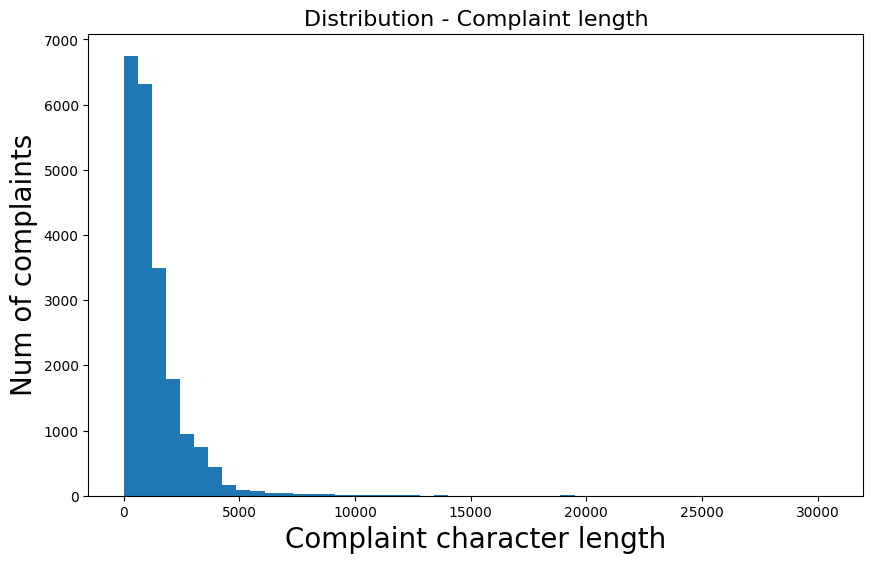

In [34]:
fig = plt.figure(figsize=(10,6))
plt.hist(df_cleaned['complaint_length'], bins=50)
plt.title('Distribution of Complaint length', fontsize=20)
plt.ylabel('Number of complaints', fontsize=14)
plt.xlabel('Complaint character length', fontsize=14)
plt.show()

#### Word Cloud

In [35]:
stopwords = set(STOPWORDS)

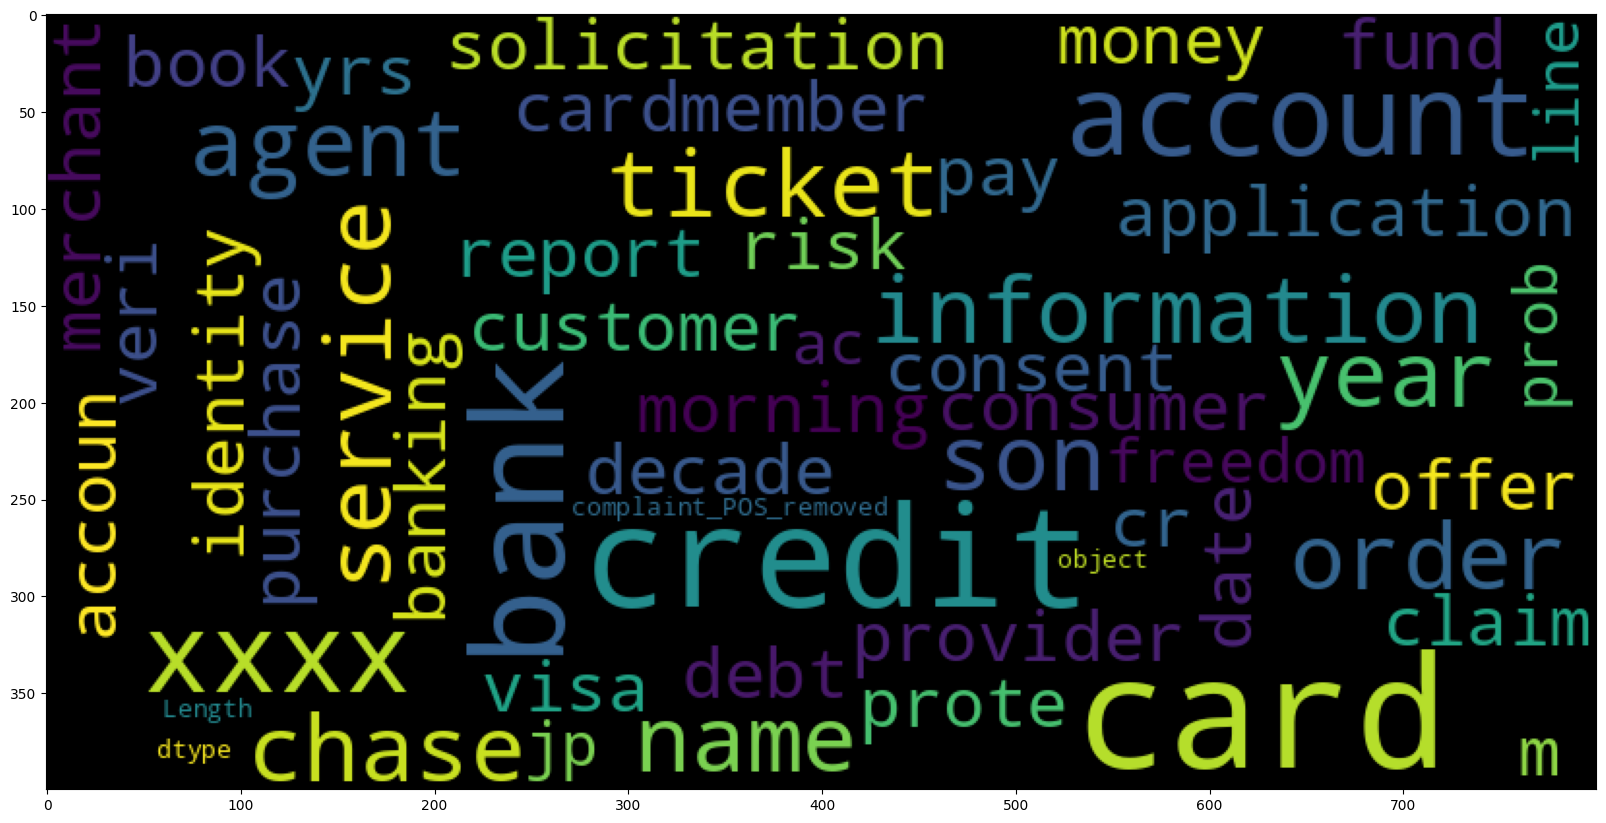

In [36]:
wordcloud = WordCloud(background_color = 'black', width = 800, height = 400, stopwords = stopwords,
                      colormap = 'viridis', max_words = 180, contour_width = 3,
                      max_font_size = 80, contour_color = 'steelblue',
                      random_state = 0).generate(str(df_cleaned['complaint_POS_removed']))

fig = plt.figure(figsize=(20,15))
plt.imshow(wordcloud)

#### Cleaning POS Tags

In [37]:
df_cleaned['complaint_clean'] = df_cleaned['complaint_POS_removed'].str.replace('-PRON-', '')
df_cleaned.sample(5)

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,complaint_clean
72164,i have had a bank account at chase for about o...,bank account chase year number claim regard pa...,bank account year number claim payment debit c...,573,bank account year number claim payment debit c...
349,i made a purchase of on through xxxx using the...,purchase xxxx chase item website apr month mon...,purchase xxxx chase item month month card item...,1332,purchase xxxx chase item month month card item...
47908,on someone between xxxx and xxxx completed una...,someone atm withdraw bank amount wfee police r...,someone bank amount police report officer depa...,405,someone bank amount police report officer depa...
223,on xxxxxxxx i used a referral link to sign up ...,xxxxxxxx link chase freedom credit card referr...,link chase freedom credit card referrer bonus ...,787,link chase freedom credit card referrer bonus ...
5900,i was shocked when i reviewed my credit report...,credit report week inaccuracy credit report cr...,credit report week inaccuracy credit report cr...,2354,credit report week inaccuracy credit report cr...


#### Unigram, bigram and trigram analysis

In [38]:
def get_top_unigrams(text, n=None):
    vec = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [49]:
common_words = get_top_unigrams(df_cleaned['complaint_clean'].values.astype('U'), 30)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
unigram.head(10)

,unigram,count
0,account,41710
1,credit,34153
2,chase,33449
3,bank,28416
4,card,25695
5,payment,21171
6,time,16011
7,charge,14676
8,day,12980
9,money,11962


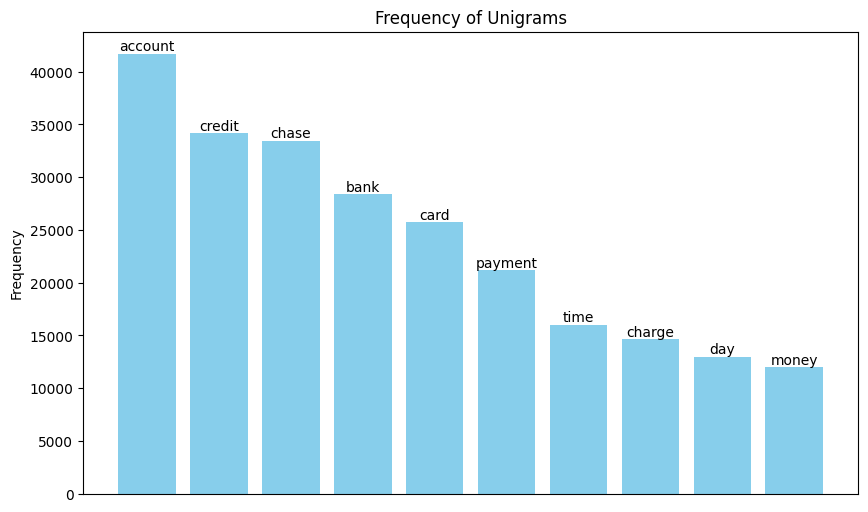

In [57]:
unigram_top_10 = unigram.sort_values('count', ascending=False).head(10)
plt.figure(figsize=(10, 6))
bars = plt.bar(unigram_top_10['unigram'], unigram_top_10['count'], color='skyblue')

# Annotate bars with values
for bar, freq in zip(bars, unigram_top_10['unigram']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(freq),
             ha='center', va='bottom')

plt.ylabel('Frequency')
plt.title('Frequency of Unigrams')
plt.xticks([])
plt.show()

In [40]:
def get_top_bigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [41]:
common_words = get_top_bigrams(df_cleaned['complaint_clean'].values.astype('U'), 30)
bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])
bigram.head(10)

,bigram,count
0,credit card,12448
1,credit report,3998
2,xxxx xxxx,3640
3,customer service,3081
4,chase credit,2732
5,bank account,2640
6,account account,2311
7,chase account,2285
8,check account,2093
9,account bank,1998


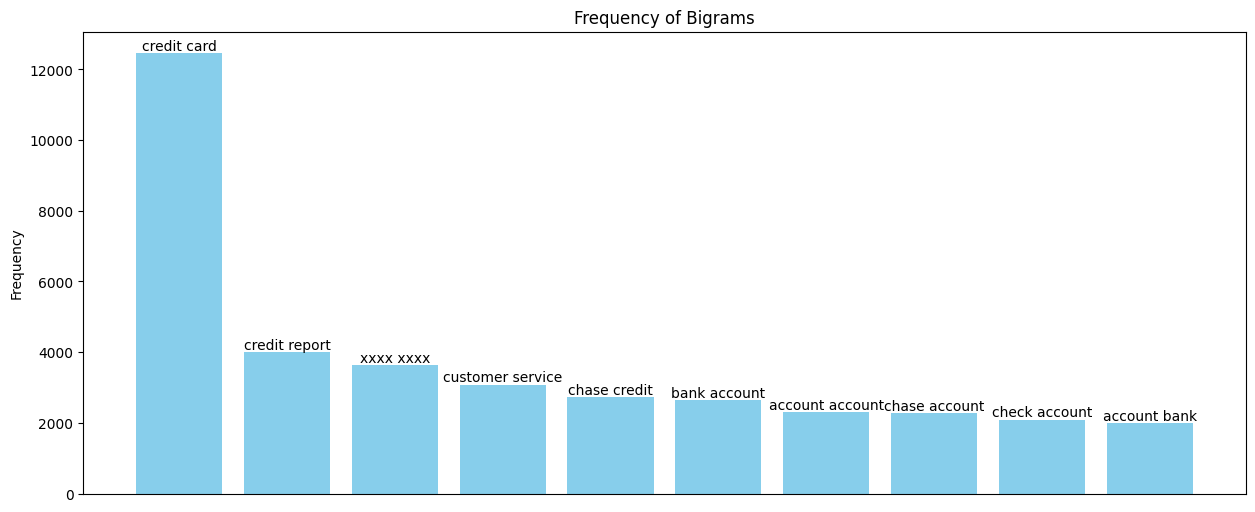

In [59]:
bigram_top_10 = bigram.sort_values('count', ascending=False).head(10)
plt.figure(figsize=(15, 6))
bars = plt.bar(bigram_top_10['bigram'], bigram_top_10['count'], color='skyblue')

# Annotate bars with values
for bar, freq in zip(bars, bigram_top_10['bigram']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(freq),
             ha='center', va='bottom')

plt.ylabel('Frequency')
plt.title('Frequency of Bigrams')
plt.xticks([])
plt.show()

In [61]:
def get_top_trigrams(text, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [63]:
common_words = get_top_trigrams(df_cleaned['complaint_clean'].values.astype('U'), 30)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
trigram.head(10)

,trigram,count
0,chase credit card,1922
1,credit card company,1018
2,credit card account,887
3,credit card credit,624
4,credit card chase,554
5,credit report credit,491
6,account credit card,461
7,charge credit card,458
8,card credit card,438
9,inquiry credit report,429


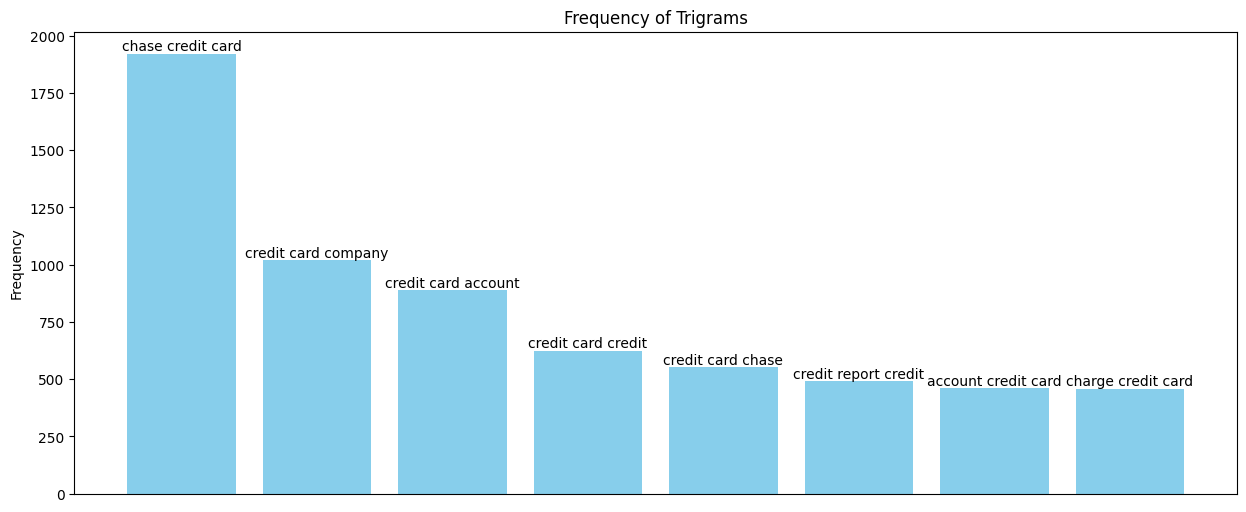

In [67]:
trigram_top_10 = trigram.sort_values('count', ascending=False).head(8)
plt.figure(figsize=(15, 6))
bars = plt.bar(trigram_top_10['trigram'], trigram_top_10['count'], color='skyblue')

# Annotate bars with values
for bar, freq in zip(bars, trigram_top_10['trigram']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(freq),
             ha='center', va='bottom')

plt.ylabel('Frequency')
plt.title('Frequency of Trigrams')
plt.xticks([])
plt.show()

#### Removing personal data marker from the text

In [45]:
def remove_allXX(text):
  return re.sub('[x]{2,}',"",text)

In [46]:
df_cleaned['complaint_clean'] = df_cleaned['complaint_clean'].swifter.apply(remove_allXX)

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [44]:
df_cleaned['complaint_clean'] = df_cleaned['complaint_clean'].str.replace('xxxx','')

In [47]:
df_cleaned.sample(10)

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,complaint_clean
7885,i am trying to close on a home and i checked m...,home credit report inquiry,home credit report inquiry,134,home credit report inquiry
31157,applied for xxxx credit cards in xxxx of a t t...,apply credit card t time sapphire freedom appl...,credit card t time sapphire freedom applicatio...,1417,credit card t time sapphire freedom applicatio...
11336,i am facing foreclosure due to conflicting mes...,foreclosure message failure action representat...,foreclosure message failure action representat...,3351,foreclosure message failure action representat...
20192,on i applied for the chase freedom xxxx world ...,chase freedom world elite amount letter inform...,chase freedom world elite amount letter inform...,303,chase freedom world elite amount letter inform...
72022,on my xxxx statement i noticed xxxx incorrect ...,statement charge wife xxxx xxxx charge account...,statement charge wife xxxx xxxx charge account...,715,statement charge wife charge account charge ...
12932,on xxxx xxxx xxxx i xxxx xxxx send a quit pay ...,quit pay money transfer xxxx siste email addre...,quit pay money transfer xxxx siste email addre...,1165,quit pay money transfer siste email address m...
33445,several weeks ago i discovered that i was char...,week xxxx chase card fraud inquiry charge rece...,week chase card fraud charge receipt amount ch...,1066,week chase card fraud charge receipt amount ch...
21758,good evening my name is xxxx xxxx i would like...,evening name xxxx compliant chase time deny mo...,name xxxx compliant chase time modification ho...,988,name compliant chase time modification home c...
8345,i have recently fallen victim to fraud on my c...,victim fraud chase account somebody debit card...,victim fraud chase account somebody number pin...,4165,victim fraud chase account somebody number pin...
71718,in late xxxx several pieces of mail containing...,piece mail contain check mailbox front post of...,mail contain check mailbox post office xxxx ch...,1267,mail contain check mailbox post office check ...


## Feature Engineering

#### TF-IDF Vectorization

In [68]:
tfidf_model = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [69]:
doc_term_mat = tfidf_model.fit_transform(df_cleaned['complaint_clean'])

## Topic Modelling

In [78]:
texts = df_cleaned['complaint_clean']
dataset = [d.split() for d in texts]

In [79]:
dictionary = Dictionary(dataset)

In [80]:
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

In [81]:
corpus = [dictionary.doc2bow(text) for text in dataset]

In [82]:
topic_nums = list(np.arange(5, 10, 1))

In [83]:
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

/home/eeshan/Documents/masters/06_NLP/venv/lib/python3.10/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning:

divide by zero encountered in scalar divide

/home/eeshan/Documents/masters/06_NLP/venv/lib/python3.10/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning:

invalid value encountered in scalar divide



In [84]:
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

5


#### Manual Topic Modelling

In [86]:
num_topics = 5

In [87]:
nmf_model = NMF(n_components=5, random_state=40)

In [91]:
nmf_model.fit(doc_term_mat)
len(tfidf_model.get_feature_names_out())

5798

In [93]:
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf_model.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['transfer', 'customer', 'claim', 'business', 'number', 'transaction', 'branch', 'day', 'chase', 'deposit', 'fund', 'check', 'money', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'application', 'letter', 'debt', 'limit', 'information', 'score', 'company', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['history', 'car', 'year', 'mortgage', 'pay', 'credit', 'date', 'auto', 'time', 'day', 'fee', 'statement', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['day', 'company', 'time', 'statement', 'service', 'claim', 'purchase', 'fraud', 'chase', 'merchant', 'dispute', 'transaction', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['foreclosure', 'document', 'sale', 'bank', 'house', 'time', 'letter', 'rate', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [95]:
topic_results = nmf_model.transform(doc_term_mat)
topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2])

In [97]:
df_cleaned['topic'] = topic_results.argmax(axis=1) 

In [102]:
df_cleaned.head(10)

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,complaint_clean,topic
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service ask ...,morning name bank cardmember service debt veri...,469,morning name bank cardmember service debt veri...,0
2,i upgraded my xxxx xxxx card in and was told b...,card agent upgrade date agent information orde...,card agent date agent information order accoun...,334,card agent date agent information order accoun...,1
10,chase card was reported on however fraudulent ...,card report application identity consent servi...,report application identity consent service cr...,209,report application identity consent service cr...,1
11,on while trying to book a xxxx xxxx ticket i c...,try book xxxx ticket offer ticket card informa...,book xxxx ticket offer ticket card information...,1424,book ticket offer ticket card information min...,1
14,my grand son give me check for i deposit it in...,son chase account fund bank account pay money ...,son chase account fund bank account money son ...,452,son chase account fund bank account money son ...,0
15,can you please remove inquiry,inquiry,inquiry,29,inquiry,1
17,with out notice jp morgan chase restricted my ...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday branch cus...,2221,jp chase account debit card tuesday branch cus...,0
20,during the summer months i experience a declin...,summer month income employment month payment e...,summer month income employment month payment e...,1342,summer month income employment month payment e...,2
21,on xxxx i made a payment to an online retailer...,xxxx payment online retailer use pay xxxx chas...,payment online retailer use pay xxxx chase web...,3444,payment online retailer use pay chase website...,3
23,i have a chase credit card which is incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,127,chase credit card datum credit report company ...,1


In [100]:
df_cleaned=df_cleaned.groupby('topic').head(5)
df_cleaned.sort_values('Topic')

KeyError: 'Topic'